# 因果建模工具篇

因果建模有两个重要的工具：`Dowhy` 和 `Pyro`。 第一个工具专注让因果推断变得容易，让新手都可以使用。第二个工具有潜力搭建具备因果思维的AI系统。我们 Causal AI 对其官方教程翻译项目见:

- https://github.com/Causal-Inference-ZeroToAll/dowhy_zh
- https://github.com/CausalAI/pyro_zh_tutorial

## Dowhy

"DoWhy" is a Python library that aims to spark causal thinking and analysis. 强调了小图灵测试的 answer questions correctly 部分，内置了 identification methods 来判断因果效应是否可估计。有了这个软件，常见的因果效应估计可以快速简单的实现。



### 一个简单例子

回答一个因果问题一般分为四个步骤

- model
- identify
- estimate
- refute

我们用一个简单例子查看 Dowhy 如何按照这四个步骤进行因果效应的估计。

         X0   Z0        Z1        W0        W1        W2        W3        W4  \
0 -0.080988  0.0  0.710624 -1.395975 -0.523405 -0.063829 -0.372831 -0.127850   
1  0.586735  0.0  0.741597 -1.383450 -0.873442  0.593386 -0.541042 -0.568472   
2 -2.094231  0.0  0.797503 -1.805279  0.786231  0.335273 -0.741417 -0.171904   
3  1.653794  0.0  0.538730 -2.503238 -1.222765  0.200874  0.326488  2.860590   
4  2.067459  0.0  0.594579  0.309990  0.475509 -0.013819 -0.401472 -0.094589   

     v0          y  
0  True   6.076045  
1  True   6.134939  
2  True   6.094959  
3  True  10.693302  
4  True  11.893258  


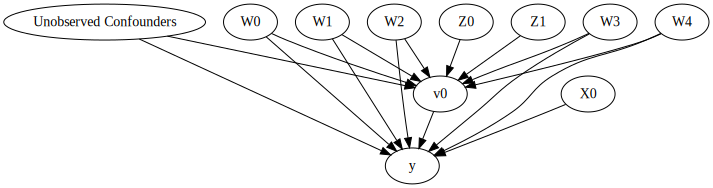

In [12]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets

data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=10000,
        treatment_is_binary=True)
df = data["df"]
print(df.head())

from graphviz import Source
Source(data["dot_graph"])

In [13]:
# 建立模型
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["dot_graph"],
        proceed_when_unidentifiable=True
        )

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


In [14]:
# 识别因果效应
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'W1', 'W0', 'W4', 'W2', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W1,W0,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W4,W2,U) = P(y|v0,W3,W1,W0,W4,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



In [15]:
# 估计因果效应
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W0+W4+W2
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W1,W0,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W0,W4,W2,U) = P(y|v0,W3,W1,W0,W4,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W1+W0+W4+W2
## Estimate
Value: 10.471796210183427

Causal Estimate is 10.471796210183427


In [16]:
# 敏感性分析
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W1+W0+W4+W2+w_random
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/gong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Add a Random Common Cause
Estimated effect:(10.471796210183427,)
New effect:(10.46377410889594,)



### $do$ 运算

这里看看 DoWhy 如何实现 $do$ 运算。See details on [doc](https://microsoft.github.io/dowhy/dowhy.api.html?highlight=do#dowhy.api.causal_data_frame.CausalAccessor.do)

`dowhy.api.causal_data_frame.CausalAccessor` 的 `do` method. The do-operation implemented with sampling. This will return a pandas.DataFrame with the outcome variable(s) replaced with samples from $P(Y|do(X=x))$. Following the notion of an intervention in a Pearlian causal model, our do-samplers implement a sequence of steps:

- Disrupt causes
- Make Effective
- Propagate and sample

`Dowhy` 中有两种实现方式，他们尝试实现 $do$ 运算的功能（但是他们都没有实现通用的 do 元算，Pyro 才能实现）

#### 第一种方式

In [28]:
import numpy as np
import pandas as pd
import dowhy.api

def get_data(N=5000):
    z = np.random.uniform(size=N)
    d = np.random.binomial(1., p=1./(1. + np.exp(-5. * z)))
    y = 2. * z + d + 0.1 * np.random.normal(size=N)
    df = pd.DataFrame({'Z': z, 'D': d, 'Y': y})
    return df

N = 5000
df = get_data(N)

,Z,D,Y
0,0.882108,1,2.685821
1,0.838964,1,2.689787
2,0.955714,1,2.787542
3,0.702490,1,2.350819
4,0.795621,1,2.707194


In [33]:
do_df = df.causal.do(x='D',
                    outcome='Y',
                    common_causes='Z',
                     variable_types={'D': 'b', 'Z': 'c', 'Y': 'c'},
                    proceed_when_unidentifiable=True)

print(df.head())
do_df.head()

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['D'] on outcome ['Y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'Z']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


          Z  D         Y
0  0.882108  1  2.685821
1  0.838964  1  2.689787
2  0.955714  1  2.787542
3  0.702490  1  2.350819
4  0.795621  1  2.707194


,Z,D,Y,propensity_score,weight
0,0.078626,1,1.084015,0.600768,1.664536
1,0.941911,1,2.910297,0.988989,1.011134
2,0.029782,0,0.172871,0.455789,2.193997
3,0.602050,1,2.322691,0.947249,1.055689
4,0.888179,1,2.819012,0.985843,1.014360


In [39]:
effect = (df[df['D'] ==1].mean() - df[df['D'] == 0].mean())['Y']
print('不考虑因果计算的效应是{}'.format(effect))
true_effect = (do_df[do_df['D'] ==1].mean() - do_df[do_df['D'] == 0].mean())['Y']
print('真实因果效应是{}'.format(true_effect))

不考虑因果计算的效应是1.632886084106672
真实因果效应是1.066663225463142


#### 第二种方式

我们再看看如何实现 do-samplers with `do_samplers.weighting_sample`

In [21]:
N = 5000
df = get_data(N)
(df[df.D == 1].mean() - df[df.D == 0].mean())['Y']

结果比真实的因果效应高 60%. 那么，让我们为这些数据建立因果模型。



In [19]:
from dowhy import CausalModel

causes = ['D']
outcomes = ['Y']
common_causes = ['Z']
model = CausalModel(df,
                    causes,
                    outcomes,
                    common_causes=common_causes,
                    proceed_when_unidentifiable=True)
identification = model.identify_effect()

from dowhy.do_samplers.weighting_sampler import WeightingSampler

sampler = WeightingSampler(df,
                           causal_model=model,
                           keep_original_treatment=True,
                           variable_types={'D': 'b', 'Z': 'c', 'Y': 'c'})

interventional_df = sampler.do_sample(None)
(interventional_df[interventional_df.D == 1].mean() - interventional_df[interventional_df.D == 0].mean())['Y']

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['D'] on outcome ['Y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'Z']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'Z']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.do_sampler:Using WeightingSampler for do sampling.
INFO:dowhy.do_sampler:Caution: do samplers assume iid data.


现在我们的结果更接近真实效应 1.0！



## Pyro



"Pyro"  是一门通用概率编程语言(PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling. It was designed with these key principles: Universal, Scalable, Flexible, Minimal. 我们需要使用这个软件，搭建复杂的因果模型。

`dowhy` 数学本质上就无法实现完全的 `do` 运算，而作为通用概率编程语言的 Pyro 才有可能真正完全实现。 

Pyro is a deep probabilistic programming language(PPL) released by Uber AI Labs. Pyro is built on top of PyTorch and is based on four fundamental principles:

- **Universal**: Pyro is a universal PPL — it can represent any computable probability distribution. How? By starting from a universal language with iteration and recursion (arbitrary Python code), and then adding random sampling, observation, and inference.
- **Scalable:** Pyro scales to large data sets with little overhead above hand-written code. How? By building modern black box optimization techniques, which use mini-batches of data, to approximate inference.
- **Minimal:** Pyro is agile and maintainable. How? Pyro is implemented with a small core of powerful, composable abstractions. Wherever possible, the heavy lifting is delegated to PyTorch and other libraries.
- **Flexible:** Pyro aims for automation when you want it and control when you need it. How? Pyro uses high-level abstractions to express generative and inference models, while allowing experts to easily customize inference.


相关资料包括：

- [Pyro 官网](https://pyro.ai)
- [Pyro 全面介绍](https://sites.google.com/view/causal-inference-zerotoall/codes/tools/pyro)
- [Pyro 官方教程汉化版](https://causalai.github.io/pyro_zh_tutorial/)

### 一个简单的例子

详情参见： https://causalai.github.io/pyro_zh_tutorial/index.html

In [31]:
import math, os, torch, pyro
import torch.distributions.constraints as constraints
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

assert pyro.__version__.startswith('1.3.0')
pyro.enable_validation(True)
pyro.clear_param_store()

data = []
data.extend([torch.tensor(1.0) for _ in range(6)])
data.extend([torch.tensor(0.0) for _ in range(4)])

def model(data):
    alpha0, beta0 = torch.tensor(10.0), torch.tensor(10.0)
    theta = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(theta), obs=data[i])
def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 2000
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()
inferred_mean = alpha_q / (alpha_q + beta_q)
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)
print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


....................
based on the data and our prior belief, the fairness of the coin is 0.530 +- 0.090


### 梯度下降法 with Pyro Low-level

我们用上面的 Pyro 程序，通过查看源代码，把里面的参数取出来进行梯度下降法

Before updated: tensor(8.5000, requires_grad=True) tensor(1., requires_grad=True)
After updated: tensor(9.0979, requires_grad=True) tensor(0.6203, requires_grad=True)
a =  9.097911834716797
b =  0.6202840209007263


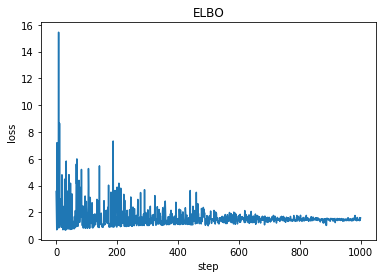

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
pyro.set_rng_seed(101)
mu = 8.5

def scale(mu):
    weight = pyro.sample("weight", dist.Normal(mu, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))
conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

def scale_parametrized_guide(mu):
    a = pyro.param("a", torch.tensor(mu))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

pyro.clear_param_store()

with pyro.poutine.trace(param_only=True) as param_capture:
    loss = loss_fn(conditioned_scale, scale_parametrized_guide, mu)
    loss.backward()
params = [site["value"].unconstrained() for site in param_capture.trace.nodes.values()]

def step(params):
    for x in params:
        x.data = x.data - lr * x.grad
        x.grad.zero_()

print("Before updated:", pyro.param('a'), pyro.param('b'))
losses, a,b  = [], [], []
lr = 0.001
num_steps = 1000
for t in range(num_steps):
    with pyro.poutine.trace(param_only=True) as param_capture:
        loss = loss_fn(conditioned_scale, scale_parametrized_guide, mu)
        loss.backward()
        losses.append(loss.data)
    params = [site["value"].unconstrained() for site in param_capture.trace.nodes.values()]

    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())
    step(params)
print("After updated:", pyro.param('a'), pyro.param('b'))


plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())

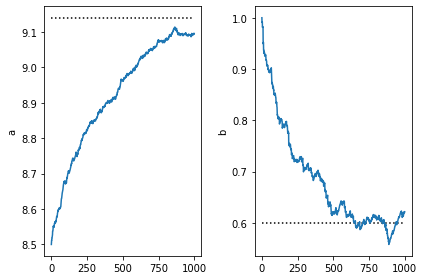

In [40]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

### $do$ 运算

除了合并观察数据的 `pyro.condition` 之外，Pyro还包含 `pyro.do`，这是 Pearl 的 do-operator 的实现，用于因果推断，其接口与 `pyro.condition` 相同。`condition` and `do` 可以自由混合和组合，使Pyro成为基于模型的因果推断的强大工具。


--- 官方教程尚未给出例子

In [219]:
def model(data):
    out = []
    alpha0, beta0 = torch.tensor(10.0), torch.tensor(10.0)
    theta = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    out.append(theta)
    test = pyro.sample('test_node', dist.Bernoulli(theta))
    out.append(test)

    for i in range(len(data)):
        out.append(pyro.sample("obs_{}".format(i), dist.Bernoulli(theta), obs=data[i]))
    return out
        
model(data)

[tensor(0.5573),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [264]:
intervened_model = pyro.poutine.do(model, data={"latent_fairness": torch.tensor(1.0)})
intervened_model(data)

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [273]:
def model(x):
    s = pyro.param("s", torch.tensor(0.5))
    z = pyro.sample("z", dist.Normal(x, s))
    y = pyro.sample("y", dist.Uniform(z-s/100, z+s/100))
    return z, y

intervened_model = pyro.poutine.do(model, data={"z": torch.tensor(1.)})
x = torch.tensor(0.)
intervened_model(x)

(tensor(1.), tensor(1.0022, grad_fn=<AddBackward0>))

## 结论


`Dowhy` 可以用于快速回答简单的因果效应估计问题，它强调了因果分析的四个步骤。但是如果要建立灵活复杂的因果模型，实现 $do$ 运算的完整功能，我们需要通用深度概率图编程语言。

- 动态控制随机函数

这样随机函数有一个特点，那就是任何一个样本，它的维度是不确定的，你无法计算部分观测的概率。也是由于其样本是动态生成的，定义指导分布的时候，无法定义一个抽样语句与模型分布中每个隐变量对应。所以也无法用那些推断算法，需要想其他办法。